In [47]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [50]:
#read data, split into datasets for the home teams and away teams
df = pd.read_csv('fullDataCleaned.csv')
print(list(df.columns))

['team_id', 'isHome', 'date', 'month', 'hour', 'doubleheader', 'isNight', 'sky', 'isDome', 'wind_direction', 'temperature_fahrenheit', 'attendance', 'wind_speed_mph', 'season_game_number', 'series_game_number', 'days_since_last_game', 'pitches_p', 'ba_p', 'iso_p', 'babip_p', 'slg_p', 'woba_p', 'xwoba_p', 'xba_p', 'hits_p', 'abs_p', 'launch_speed_p', 'launch_angle_p', 'spin_rate_p', 'velocity_p', 'effective_speed_p', 'whiffs_p', 'swings_p', 'takes_p', 'eff_min_vel_p', 'release_extension_p', 'pitcher_run_exp_p', 'run_exp_p', 'pitches_h', 'ba_h', 'iso_h', 'babip_h', 'slg_h', 'woba_h', 'xwoba_h', 'xba_h', 'hits_h', 'abs_h', 'launch_speed_h', 'launch_angle_h', 'spin_rate_h', 'velocity_h', 'effective_speed_h', 'whiffs_h', 'swings_h', 'takes_h', 'eff_min_vel_h', 'release_extension_h', 'pitcher_run_exp_h', 'run_exp_h', 'dayOfWeek', 'duration', 'score', 'opp_score', 'score_diff', 'scoreLine', 'opp_ScoreLine', 'outcome', 'pitches_diff', 'ba_diff', 'iso_diff', 'babip_diff', 'slg_diff', 'woba_diff

In [64]:
filtered_df = df[(df['outcome'] == 'Close Win') | (df['outcome'] == 'Good Win') | (df['outcome'] == 'Strong Win') | (df['outcome'] == 'Blowout Win')]
len(filtered_df)

2430

In [65]:
cat_cols = ['team_id', 'date', 'sky', 'dayOfWeek', 'scoreLine',
       'opp_ScoreLine', 'outcome', 'wind_direction']
num_cols = ['isHome', 'month', 'hour', 'doubleheader', 'isNight', 'isDome', 'temperature_fahrenheit', 'attendance', 'wind_speed_mph', 'season_game_number', 
            'series_game_number', 'days_since_last_game', 'pitches_h', 'ba_h', 'iso_h', 
            'babip_h', 'slg_h', 'woba_h', 'xwoba_h', 'xba_h', 'hits_h', 'abs_h', 'launch_speed_h', 'launch_angle_h', 'spin_rate_h', 'velocity_h', 'effective_speed_h', 'whiffs_h', 'swings_h', 'takes_h', 
            'eff_min_vel_h', 'release_extension_h', 'pitcher_run_exp_h', 'run_exp_h', 'duration', 'score', 'opp_score', 'score_diff', 'pitches_diff', 
            'ba_diff', 'iso_diff', 'babip_diff', 'slg_diff', 'woba_diff', 'xwoba_diff', 'xba_diff', 'hits_diff', 'abs_diff', 'launch_speed_diff', 'launch_angle_diff', 'spin_rate_diff', 'velocity_diff', 
            'effective_speed_diff', 'whiffs_diff', 'swings_diff', 'takes_diff', 'eff_min_vel_diff', 'release_extension_diff', 'pitcher_run_exp_diff', 'run_exp_diff', 'pitches_above_avg', 'ba_above_avg', 
            'iso_above_avg', 'babip_above_avg', 'slg_above_avg', 'woba_above_avg', 'xwoba_above_avg', 'xba_above_avg', 'hits_above_avg', 'abs_above_avg', 'launch_speed_above_avg', 
            'launch_angle_above_avg', 'spin_rate_above_avg', 'velocity_above_avg', 'effective_speed_above_avg', 'whiffs_above_avg', 'swings_above_avg', 'takes_above_avg', 'eff_min_vel_above_avg', 
            'release_extension_above_avg', 'pitcher_run_exp_above_avg', 'run_exp_above_avg']
df_cat = filtered_df[cat_cols]
df_num = filtered_df[num_cols]

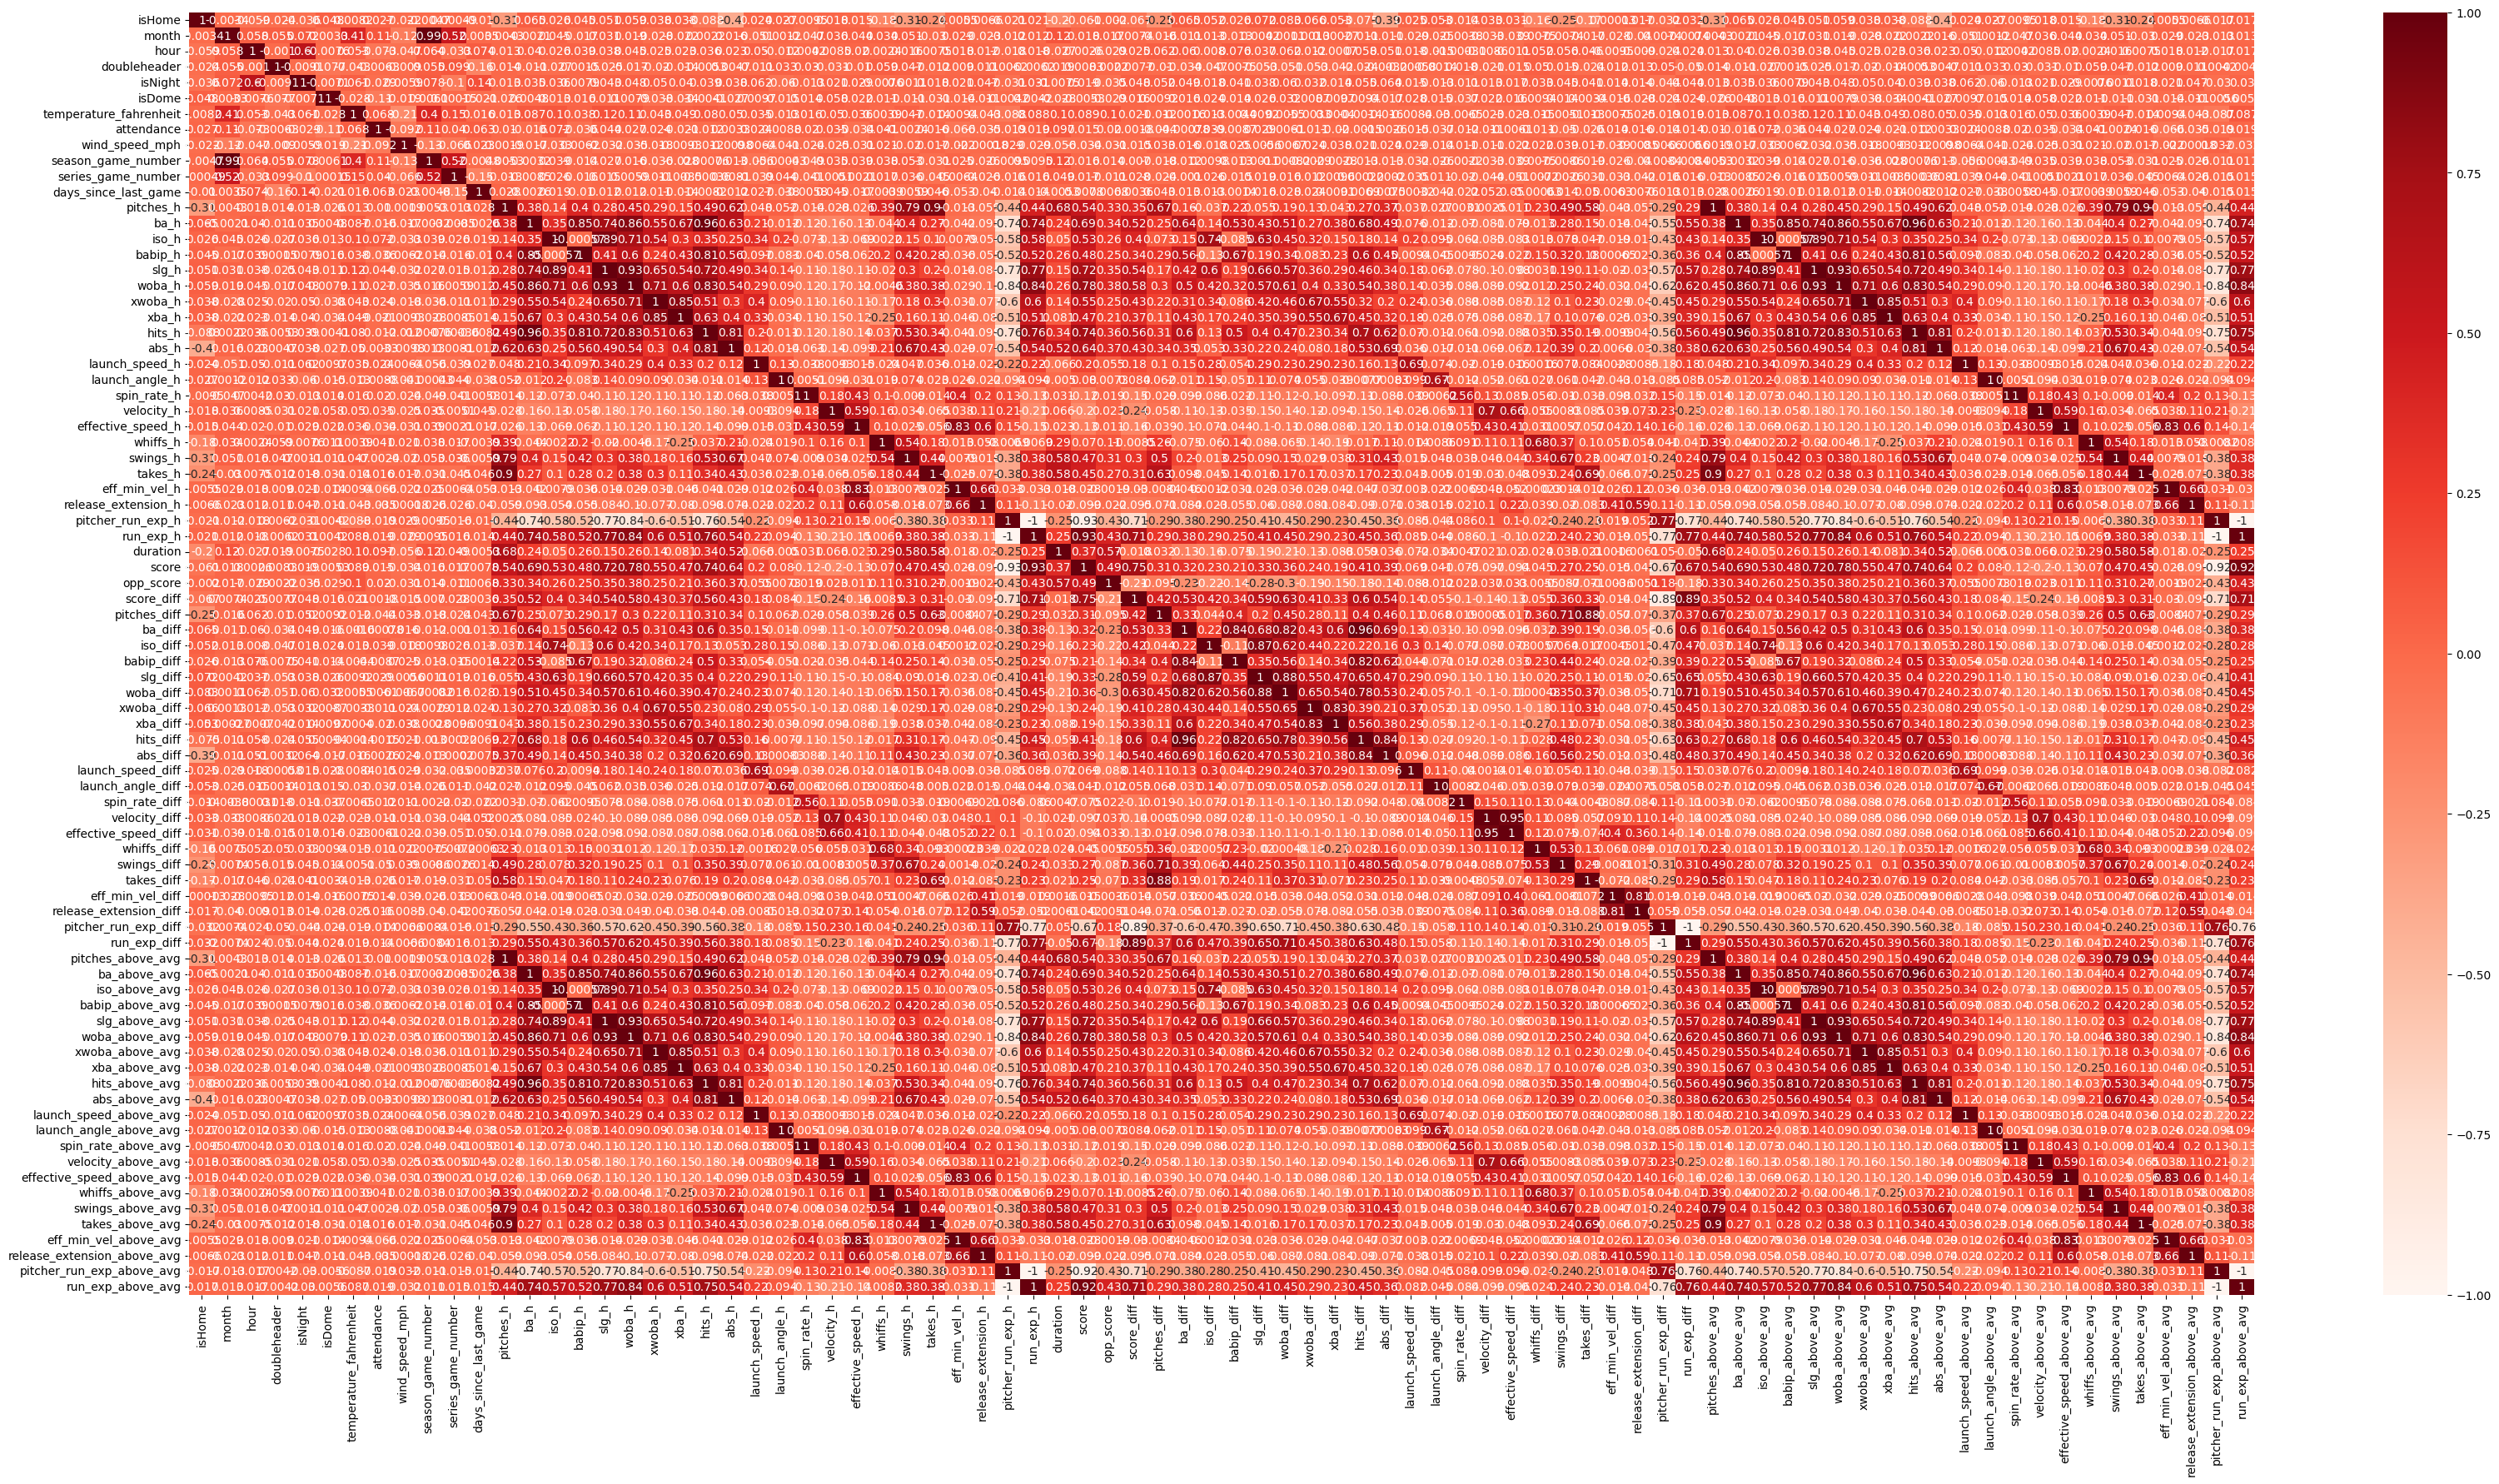

In [66]:
#plot a correlation matrix
plt.figure(figsize=(40,20))
cor = df_num.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [71]:
#Our model will try to predict home team runs using the difference between the home and away team's hitting metrics 
#
#See what variables are most correlated to runs
cor_target = abs(cor['score_diff'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.50]
relevant_features.index.tolist()

['ba_h',
 'slg_h',
 'woba_h',
 'hits_h',
 'pitcher_run_exp_h',
 'run_exp_h',
 'score',
 'score_diff',
 'ba_diff',
 'slg_diff',
 'woba_diff',
 'hits_diff',
 'abs_diff',
 'pitcher_run_exp_diff',
 'run_exp_diff',
 'ba_above_avg',
 'slg_above_avg',
 'woba_above_avg',
 'hits_above_avg',
 'pitcher_run_exp_above_avg',
 'run_exp_above_avg']

In [73]:
#create explanatory and response variable subsets
#'slg_h', 'woba_h', 'pitcher_run_exp_h', 'run_exp_h', 'score', 'ba_diff', 'slg_diff', 'woba_diff', 'xwoba_diff', 'hits_diff', 'pitcher_run_exp_diff', 'run_exp_diff',
#'slg_above_avg', 'woba_above_avg', 'pitcher_run_exp_above_avg', 'run_exp_above_avg'
x_df = df_num[['ba_h',
 'slg_h',
 'woba_h',
 'hits_h',
 #'pitcher_run_exp_h',
 #'run_exp_h',
 'score',
 'ba_diff',
 'slg_diff',
 'woba_diff',
 'hits_diff',
 'abs_diff',
 #'pitcher_run_exp_diff',
 #'run_exp_diff',
 'ba_above_avg',
 'slg_above_avg',
 'woba_above_avg',
 'hits_above_avg',]]
 #'pitcher_run_exp_above_avg',
 #'run_exp_above_avg']]
y_df = df_num[['score_diff']]

In [74]:
#Split data into training and test sets
x_df_train, x_df_test, y_df_train, y_df_test = train_test_split(x_df, y_df, test_size = 0.2)

In [75]:
#Initialize Linear Model
model = LinearRegression()

In [76]:
#Fit a model to the training data and output a dataframe of the coefficients
model.fit(x_df_train, y_df_train)
pd.DataFrame(data = np.transpose(model.coef_), index = x_df.columns, columns = ['Coeff'])

,Coeff
ba_h,16.472478
slg_h,-2.143009
woba_h,-6.821260
hits_h,-0.396722
score,0.856094
ba_diff,-41.548025
slg_diff,4.675000
woba_diff,13.421476
hits_diff,1.024610
abs_diff,-0.049955


In [77]:
#Predict test set values
predictions = model.predict(x_df_test)

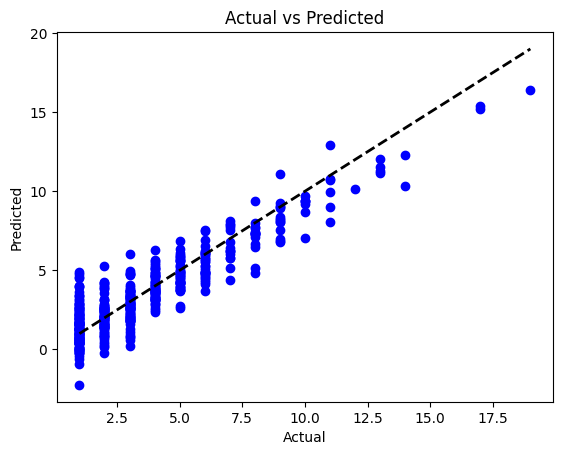

In [78]:
#Scatter plot comparing actual values to predicted values
plt.scatter(y_df_test, predictions, color='blue')
plt.plot([y_df_test.min(), y_df_test.max()], [y_df_test.min(), y_df_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [79]:
#Check MSE
mean_squared_error(y_df_test, predictions)

1.3589027356100427

In [95]:
#Try a polynomial model instead
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly_features.fit_transform(x_df_train)
x_test_poly = poly_features.transform(x_df_test)

In [96]:
#Initialize and fit new model
model2 = LinearRegression()
model2.fit(x_train_poly, y_df_train)

LinearRegression()

In [97]:
#Using the created model, predict the y-values of the test data
predictions = model2.predict(x_test_poly)

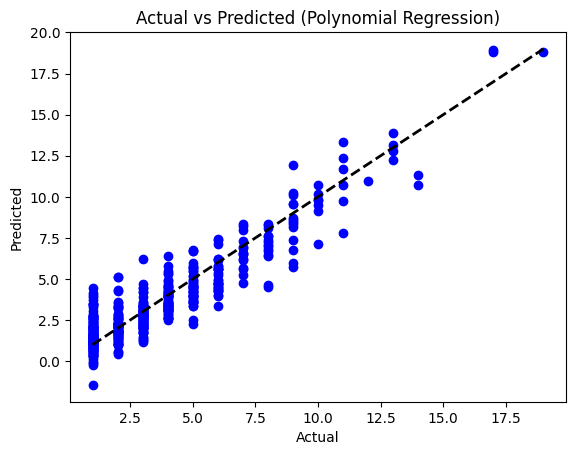

In [98]:
#Scatter plot comparing actual values to predicted values
plt.scatter(y_df_test, predictions, color='blue')
plt.plot([y_df_test.min(), y_df_test.max()], [y_df_test.min(), y_df_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Polynomial Regression)')
plt.show()

In [94]:
#After testing polynomial models with degree 2-6, degree 3 produced the lowest MSE
mean_squared_error(y_df_test, predictions)

58.75592307389883